In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.linear_model import LinearRegression

import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation, DataService

In [2]:
# 所有filter函数
def filter_001_1(df):
    '''衡量当前波动率高低的过滤器'''
    log_ratio = np.log(df['close'] / df['close'].shift(1))
    hv = log_ratio.rolling(20).std()
    return hv

def filter_001_2(df):
    '''ATR过滤器'''
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(14).mean()
    return atr

def filter_001_3_keltner_channels(df, ema_period=20, atr_period=10, multiplier=2):
    '''凯尔特纳通道：基于ATR的波动通道'''
    ema = df['close'].ewm(span=ema_period, adjust=False).mean()
    
    # 计算ATR
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.ewm(span=atr_period, adjust=False).mean()
    
    # 计算通道宽度
    channel_width = multiplier * atr
    return (df['close'] - (ema - channel_width)) / (2 * channel_width)

def filter_002_1(df):
    '''衡量当前成交量高低的过滤器'''
    volume_mean = df['volume'].rolling(20).mean()
    volume_deviation = (df['volume'] - volume_mean) / volume_mean
    return volume_deviation

def filter_002_2_obv(df):
    '''能量潮指标：累积成交量平衡'''
    obv = (np.sign(df['close'].diff()) * df['volume'])
    obv = obv.cumsum()
    return obv

def filter_002_3_vwap(df):
    '''成交量加权平均价'''
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
    return vwap

def filter_003(df):
    '''衡量当前相对位置高低的过滤器'''
    up = df['high'].rolling(20).max()
    down = df['low'].rolling(20).min()
    price_position = (df['close'] - down) / (up - down)
    return price_position

def filter_004(df):
    '''衡量短期价格波动快慢的过滤器'''
    std_5 = df['close'].rolling(5).std()
    std_30 = df['close'].rolling(30).std()
    price_fluctuation = std_5 / std_30
    return price_fluctuation

def filter_005(df):
    '''
    衡量买卖压力的比例的过滤器
    通过taker_buy_volume和总成交量计算买卖不平衡，反映市场中的净买压或卖压。
    '''
    imbalance = 2 * df['taker_buy_volume'] / df['volume'] - 1
    return imbalance

def filter_006(df):
    '''
    衡量平均交易量的过滤器
    计算每笔交易的平均成交量，反映市场交易规模的大小，指示机构或散户活动。
    '''
    average_trade_size = df['volume'] / df['trade_count']
    return average_trade_size

def filter_007(df):
    '''
    衡量 candle body 相对价格范围的大小的过滤器
    衡量K线实体的相对大小，反映价格走势的强弱（如强趋势或市场犹豫）。
    '''
    body = abs(df['close'] - df['open'])
    range_ = df['high'] - df['low']
    body_to_range_ratio = body / range_
    return body_to_range_ratio

def filter_008(df):
    '''衡量上影线相对价格范围的大小的过滤器'''
    upper_wick = df['high'] - df[['open', 'close']].max(axis=1)
    range_ = df['high'] - df['low']
    upper_wick_ratio = upper_wick / range_
    return upper_wick_ratio

def filter_009(df):
    '''衡量下影线相对价格范围的大小的过滤器'''
    lower_wick = df[['open', 'close']].min(axis=1) - df['low']
    range_ = df['high'] - df['low']
    lower_wick_ratio = lower_wick / range_
    return lower_wick_ratio

def filter_010_1(df, period=14):
    '''
    衡量RSI的过滤器，衡量价格的超买或超卖状态。
    '''
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace([np.inf, -np.inf], np.nan).fillna(0)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def filter_010_2_mfi(df, period=14):
    '''资金流量指数：结合价格和成交量的RSI变体'''
    # 计算典型价格
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    
    # 计算原始资金流
    raw_money_flow = typical_price * df['volume']
    
    # 计算正向和负向资金流
    money_flow_direction = np.where(typical_price > typical_price.shift(1), 1, -1)
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    
    # 计算资金比率
    money_ratio = positive_flow.rolling(period).sum() / negative_flow.rolling(period).sum()
    money_ratio = money_ratio.replace([np.inf, -np.inf], np.nan).fillna(1)
    
    # 计算MFI
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

def filter_011(df, short_period=12, long_period=26):
    '''
    衡量MACD的过滤器，可用于识别趋势反转点
    '''
    short_ema = df['close'].ewm(span=short_period, adjust=False).mean()
    long_ema = df['close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    return macd

def filter_012_aroon_up(df, period=14):
    '''阿隆上升指标：衡量价格创新高的能力'''
    # 计算最高价在周期内的位置
    high_idx = df['high'].rolling(period).apply(lambda x: x.argmax(), raw=True)
    aroon_up = 100 * (period - high_idx) / period
    return aroon_up

def filter_013_aroon_down(df, period=14):
    '''阿隆下降指标：衡量价格创新低的能力'''
    # 计算最低价在周期内的位置
    low_idx = df['low'].rolling(period).apply(lambda x: x.argmin(), raw=True)
    aroon_down = 100 * (period - low_idx) / period
    return aroon_down

def filter_014_aroon_oscillator(df, period=14):
    '''阿隆震荡器：衡量趋势强度'''
    aroon_up = filter_012_aroon_up(df, period)
    aroon_down = filter_013_aroon_down(df, period)
    return aroon_up - aroon_down

def filter_015_chaikin_money_flow(df, period=20):
    '''
    Chaikin资金流(CMF)：结合价格和成交量的资金流向指标
    表示资金流入和流出市场的强度，通常用于识别趋势的持续性或反转。
    CMF值大于0表示资金流入，值小于0表示资金流出。
    '''
    # 计算资金流乘数
    money_flow_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    money_flow_multiplier = money_flow_multiplier.replace([np.inf, -np.inf], 0).fillna(0)
    
    # 计算资金流量
    money_flow_volume = money_flow_multiplier * df['volume']
    
    # 计算CMF
    cmf = money_flow_volume.rolling(period).sum() / df['volume'].rolling(period).sum()
    return cmf

def filter_020_volume_price_trend(df):
    '''量价趋势指标：结合价格变动和成交量'''
    price_change = df['close'].pct_change()
    vpt = (price_change * df['volume']).cumsum()
    return vpt

def cmq_0702_factor(df):
    """
    改进点：
    1. 结合成交量分布和价格位置双重确认
    2. 增加交易意图分析（主动买入/卖出）
    3. 使用动态时间窗口
    """
    # 动态窗口：根据波动率调整回溯期
    volatility = df['close'].pct_change().rolling(96).std()
    
    # 处理NaN和inf问题 - 填充缺失值，避免除以零
    volatility = volatility.fillna(volatility.mean())  # 填充NaN为均值
    volatility = volatility.replace(0, 1e-6)           # 避免除以零
    volatility = np.clip(volatility, 1e-6, None)        # 确保最小正值
    
    # 计算窗口大小并确保为整数
    window_size = (960 / (volatility * 100 + 1))
    window_size = np.nan_to_num(window_size, nan=480)   # 替换NaN为默认值
    window_size = np.clip(window_size, 480, 1440).astype(int)
    
    # 预计算关键指标
    avg_price = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ret = (df['close'] - df['open']) / df['open']
    abs_ret = np.abs(ret)
    buy_power = df['taker_buy_volume'] / df['volume']
    
    # 核心指标：量价确认得分
    # 结合价格变动方向、主动买入比例和交易规模
    S = np.sign(ret) * abs_ret * buy_power * np.log1p(df['volume'])
    
    # 初始化因子值数组
    factor_values = np.full(len(df), np.nan)
    
    # 找到有效的起始索引（确保有足够数据）
    start_idx = max(np.max(window_size), 96) + 1
    
    for i in range(start_idx, len(df)):
        w_size = window_size[i]
        start_idx = i - w_size
        end_idx = i - 1
        
        # 提取窗口数据
        window_avg_price = avg_price.iloc[start_idx:end_idx].values
        window_volume = df['volume'].iloc[start_idx:end_idx].values
        window_S = S.iloc[start_idx:end_idx].values
        
        # 按S值降序排序（聪明钱交易在前）
        sorted_idx = np.argsort(-window_S)
        sorted_volume = window_volume[sorted_idx]
        sorted_avg_price = window_avg_price[sorted_idx]
        
        # 动态阈值（基于波动率）
        threshold_ratio = 0.3 - 0.15 * (volatility[i] / volatility.max())  # 波动大时降低阈值
        threshold = np.sum(window_volume) * threshold_ratio
        
        # 识别聪明钱交易
        cum_volume = np.cumsum(sorted_volume)
        smart_mask = cum_volume <= threshold
        
        if np.any(smart_mask):
            # 计算聪明钱VWAP（加权平均价）
            smart_vwap = np.sum(sorted_avg_price[smart_mask] * 
                              sorted_volume[smart_mask]) / np.sum(sorted_volume[smart_mask])
            
            # 计算整体VWAP
            all_vwap = np.sum(window_avg_price * window_volume) / np.sum(window_volume)
            
            # 添加市场状态调整
            if all_vwap > window_avg_price[-96:].mean():  # 近期上涨
                factor_values[i] = smart_vwap / all_vwap
            else:  # 近期下跌
                factor_values[i] = 2 - (smart_vwap / all_vwap)  # 反转因子方向
    
    return pd.Series(-factor_values, index=df.index)

def zhongxin_0703_factor(df, window=20):
    """
    改进：引入分形市场理论，识别不同波动周期中的重心变化
    金融意义：捕捉市场结构变化，识别趋势转折点
    """
    df = df.copy()
    # 计算波动率分形维度
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std()
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # 分形维度加权
        fractal_weights = group['fractal'].values
        
        # 上涨K线分形加权重心
        up_mask = group['close'] > group['open']
        if up_mask.any():
            up_weights = fractal_weights[up_mask] * group.loc[up_mask, 'volume']
            G_u = np.sum(time_idx[up_mask] * up_weights) / up_weights.sum()
        else:
            G_u = np.nan
            
        # 下跌K线分形加权重心
        down_mask = group['close'] < group['open']
        if down_mask.any():
            down_weights = fractal_weights[down_mask] * group.loc[down_mask, 'volume']
            G_d = np.sum(time_idx[down_mask] * down_weights) / down_weights.sum()
        else:
            G_d = np.nan
            
        daily_results.append({
            'date': date,
            'G_u': G_u,
            'G_d': G_d,
            'avg_fractal': fractal_weights.mean()
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # 分形状态感知回归
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # 分形状态作为交互项
        X = train_data[['G_u', 'avg_fractal']].values
        y = train_data['G_d'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_u']) or pd.isna(current['G_d']):
            residuals.append(np.nan)
        else:
            pred_G_d = model.predict([[current['G_u'], current['avg_fractal']]])[0]
            residuals.append(current['G_d'] - pred_G_d)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # 分形波动调整
    fractal_level = daily_df['avg_fractal'].rolling(5).mean()
    daily_df['factor'] = daily_df['residual'] * fractal_level
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return (-df['factor_value']).clip(upper=12)

def zhongxin_0708_factor(df, window=94):
    # 复制数据避免修改原始数据
    df = df.copy()
    
    # 1. 向量化计算基础指标
    df['range'] = (df['high'] - df['low']) / df['open']
    df['fractal'] = df['range'].rolling(5).std() / df['range'].rolling(20).std().replace(0, 1e-5)
    df['is_up'] = (df['close'] > df['open']).astype(int)
    df['is_down'] = (df['close'] < df['open']).astype(int)
    
    # 2. 向量化重心计算
    def vectorized_center(group, direction):
        dir_col = f'is_{direction}'
        # 获取分组索引和权重
        idx = group.index
        weights = group['fractal'] * group['volume']
        mask = (group[dir_col] == 1)
        
        # 向量化计算
        cum_weights = weights.where(mask, 0).cumsum()
        cum_weighted_idx = (pd.Series(range(len(group)), index=idx)
                          .where(mask, 0) * weights).cumsum()
        
        # 计算重心并处理边界条件
        center = cum_weighted_idx / cum_weights
        center.iloc[:4] = np.nan  # 前4个点不计算
        return center
    
    # 按日分组并行计算
    df['G_u'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'up'))
                 .reset_index(level=0, drop=True))
    
    df['G_d'] = (df.groupby(pd.Grouper(freq='D'))
                 .apply(lambda g: vectorized_center(g, 'down'))
                 .reset_index(level=0, drop=True))
    
    # 3. 滚动窗口向量化
    df['avg_fractal'] = df['fractal'].rolling(24, min_periods=12).mean()
    
    # 预计算有效索引
    valid_idx = df.dropna(subset=['G_u', 'G_d', 'avg_fractal']).index
    regression_data = np.full(len(df), np.nan)
    
    # 4. 滚动回归优化
    # 预计算累积矩阵 (X'X 和 X'y)
    X = df[['G_u', 'avg_fractal']].values
    y = df['G_d'].values
    
    # 初始化存储
    XTX = np.zeros((len(df), 2, 2))
    XTy = np.zeros((len(df), 2))
    valid_mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y)
    
    # 批量计算外积
    for i in range(len(df)):
        if valid_mask[i]:
            x_vec = X[i]
            XTX[i] = np.outer(x_vec, x_vec)
            XTy[i] = x_vec * y[i]
    
    # 计算累积和
    cum_XTX = np.nancumsum(XTX, axis=0)
    cum_XTy = np.nancumsum(XTy, axis=0)
    
    # 5. 向量化滚动回归
    for i in range(window, len(df)):
        start = i - window
        
        # 使用累积差计算窗口矩阵
        window_XTX = cum_XTX[i-1] - (cum_XTX[start-1] if start > 0 else 0)
        window_XTy = cum_XTy[i-1] - (cum_XTy[start-1] if start > 0 else 0)
        
        # 检查有效数据点数
        window_points = np.count_nonzero(valid_mask[start:i])
        if window_points < 10:
            continue
            
        try:
            # 求解线性方程组
            coeffs = np.linalg.solve(window_XTX, window_XTy)
            pred = X[i] @ coeffs
            residual = y[i] - pred
            regression_data[i] = residual * df['avg_fractal'].iloc[i]
        except np.linalg.LinAlgError:
            continue
    
    # 6. 后处理
    factor_series = pd.Series(-regression_data, index=df.index)
    return factor_series.fillna(0)

In [3]:
# 主程序
def calculate_filter_correlations():
    # 获取数据
    ds = DataService()
    df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]
    
    # 检查数据列是否完整
    required_columns = {'open', 'high', 'low', 'close', 'volume', 
                       'taker_buy_volume', 'trade_count'}
    missing_columns = required_columns - set(df.columns)
    
    if missing_columns:
        print(f"警告: 数据中缺少以下列: {missing_columns}")
        print("将跳过依赖这些列的filter计算")
    
    # 准备所有filter函数
    filters = {
        '001_1_volatility_20std': filter_001_1,
        '001_2_ATR_14': filter_001_2,
        '001_3_Keltner': lambda d: filter_001_3_keltner_channels(d),
        '002_1_volume_deviation': filter_002_1,
        '002_2_OBV': filter_002_2_obv,
        '002_3_VWAP': filter_002_3_vwap,
        '003_price_position': filter_003,
        '004_volatility_ratio': filter_004,
        '005_buy_sell_imbalance': filter_005 if 'taker_buy_volume' in df.columns else None,
        '006_avg_trade_size': filter_006 if 'trade_count' in df.columns else None,
        '007_body_ratio': filter_007,
        '008_upper_wick_ratio': filter_008,
        '009_lower_wick_ratio': filter_009,
        '010_1_RSI_14': lambda d: filter_010_1(d, 14),
        '010_2_MFI_14': lambda d: filter_010_2_mfi(d, 14),
        '011_MACD': lambda d: filter_011(d),
        '012_aroon_up': lambda d: filter_012_aroon_up(d, 14),
        '013_aroon_down': lambda d: filter_013_aroon_down(d, 14),
        '014_aroon_osc': lambda d: filter_014_aroon_oscillator(d, 14),
        '015_CMF_20': lambda d: filter_015_chaikin_money_flow(d, 20),
        '020_VPT': filter_020_volume_price_trend,
        '0702_聪明钱': cmq_0702_factor,
        '0703_时间重心偏离': zhongxin_0703_factor,
        '0708_时间重心偏离_分形市场': zhongxin_0708_factor
    }
    
    # 创建结果DataFrame
    results = pd.DataFrame(index=df.index)
    
    # 计算所有filter值
    for name, func in filters.items():
        if func is None:
            continue  # 跳过不可用的filter
            
        try:
            print(f"计算filter: {name}")
            results[name] = func(df)
        except Exception as e:
            print(f"计算{name}时出错: {str(e)}")
    
    # 计算相关性矩阵
    correlation_matrix = results.corr()
    
    # 可视化相关性矩阵
    plt.figure(figsize=(18, 15))
    sns.heatmap(correlation_matrix, 
                annot=True, 
                fmt=".2f", 
                cmap='coolwarm',
                center=0,
                vmin=-1, 
                vmax=1,
                linewidths=0.5,
                annot_kws={"size": 9})
    plt.title('Filter Correlation Matrix', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # 找出高相关性的因子对（|corr| > 0.8）
    high_corr_pairs = []
    filter_names = correlation_matrix.columns
    
    # 遍历上三角矩阵（避免重复）
    for i in range(len(filter_names)):
        for j in range(i+1, len(filter_names)):
            corr_value = correlation_matrix.iloc[i, j]
            if abs(corr_value) > 0.75:
                pair = (
                    filter_names[i], 
                    filter_names[j], 
                    corr_value
                )
                high_corr_pairs.append(pair)
    
    # 按相关性绝对值排序
    high_corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)
    
    # 打印高相关性因子对
    if high_corr_pairs:
        print("\n" + "="*70)
        print("高度相关的因子对 (|correlation| > 0.75):")
        print("="*70)
        for pair in high_corr_pairs:
            direction = "正相关" if pair[2] > 0 else "负相关"
            print(f"{pair[0]} 和 {pair[1]}: {pair[2]:.4f} ({direction})")
        print("="*70)
    
    # 返回结果
    return correlation_matrix, results, high_corr_pairs

计算filter: 001_1_volatility_20std
计算filter: 001_2_ATR_14
计算filter: 001_3_Keltner
计算filter: 002_1_volume_deviation
计算filter: 002_2_OBV
计算filter: 002_3_VWAP
计算filter: 003_price_position
计算filter: 004_volatility_ratio
计算filter: 005_buy_sell_imbalance
计算filter: 006_avg_trade_size
计算filter: 007_body_ratio
计算filter: 008_upper_wick_ratio
计算filter: 009_lower_wick_ratio
计算filter: 010_1_RSI_14
计算filter: 010_2_MFI_14
计算filter: 011_MACD
计算filter: 012_aroon_up
计算filter: 013_aroon_down
计算filter: 014_aroon_osc
计算filter: 015_CMF_20
计算filter: 020_VPT
计算filter: 0702_聪明钱
计算filter: 0703_时间重心偏离
计算filter: 0708_时间重心偏离_分形市场

高度相关的因子对 (|correlation| > 0.75):
002_2_OBV 和 020_VPT: 0.9854 (正相关)
001_3_Keltner 和 010_1_RSI_14: 0.9740 (正相关)
001_3_Keltner 和 003_price_position: 0.8747 (正相关)
012_aroon_up 和 014_aroon_osc: 0.8495 (正相关)
013_aroon_down 和 014_aroon_osc: -0.8468 (负相关)
003_price_position 和 010_1_RSI_14: 0.8068 (正相关)
010_1_RSI_14 和 010_2_MFI_14: 0.7854 (正相关)
001_3_Keltner 和 010_2_MFI_14: 0.7809 (正相关)


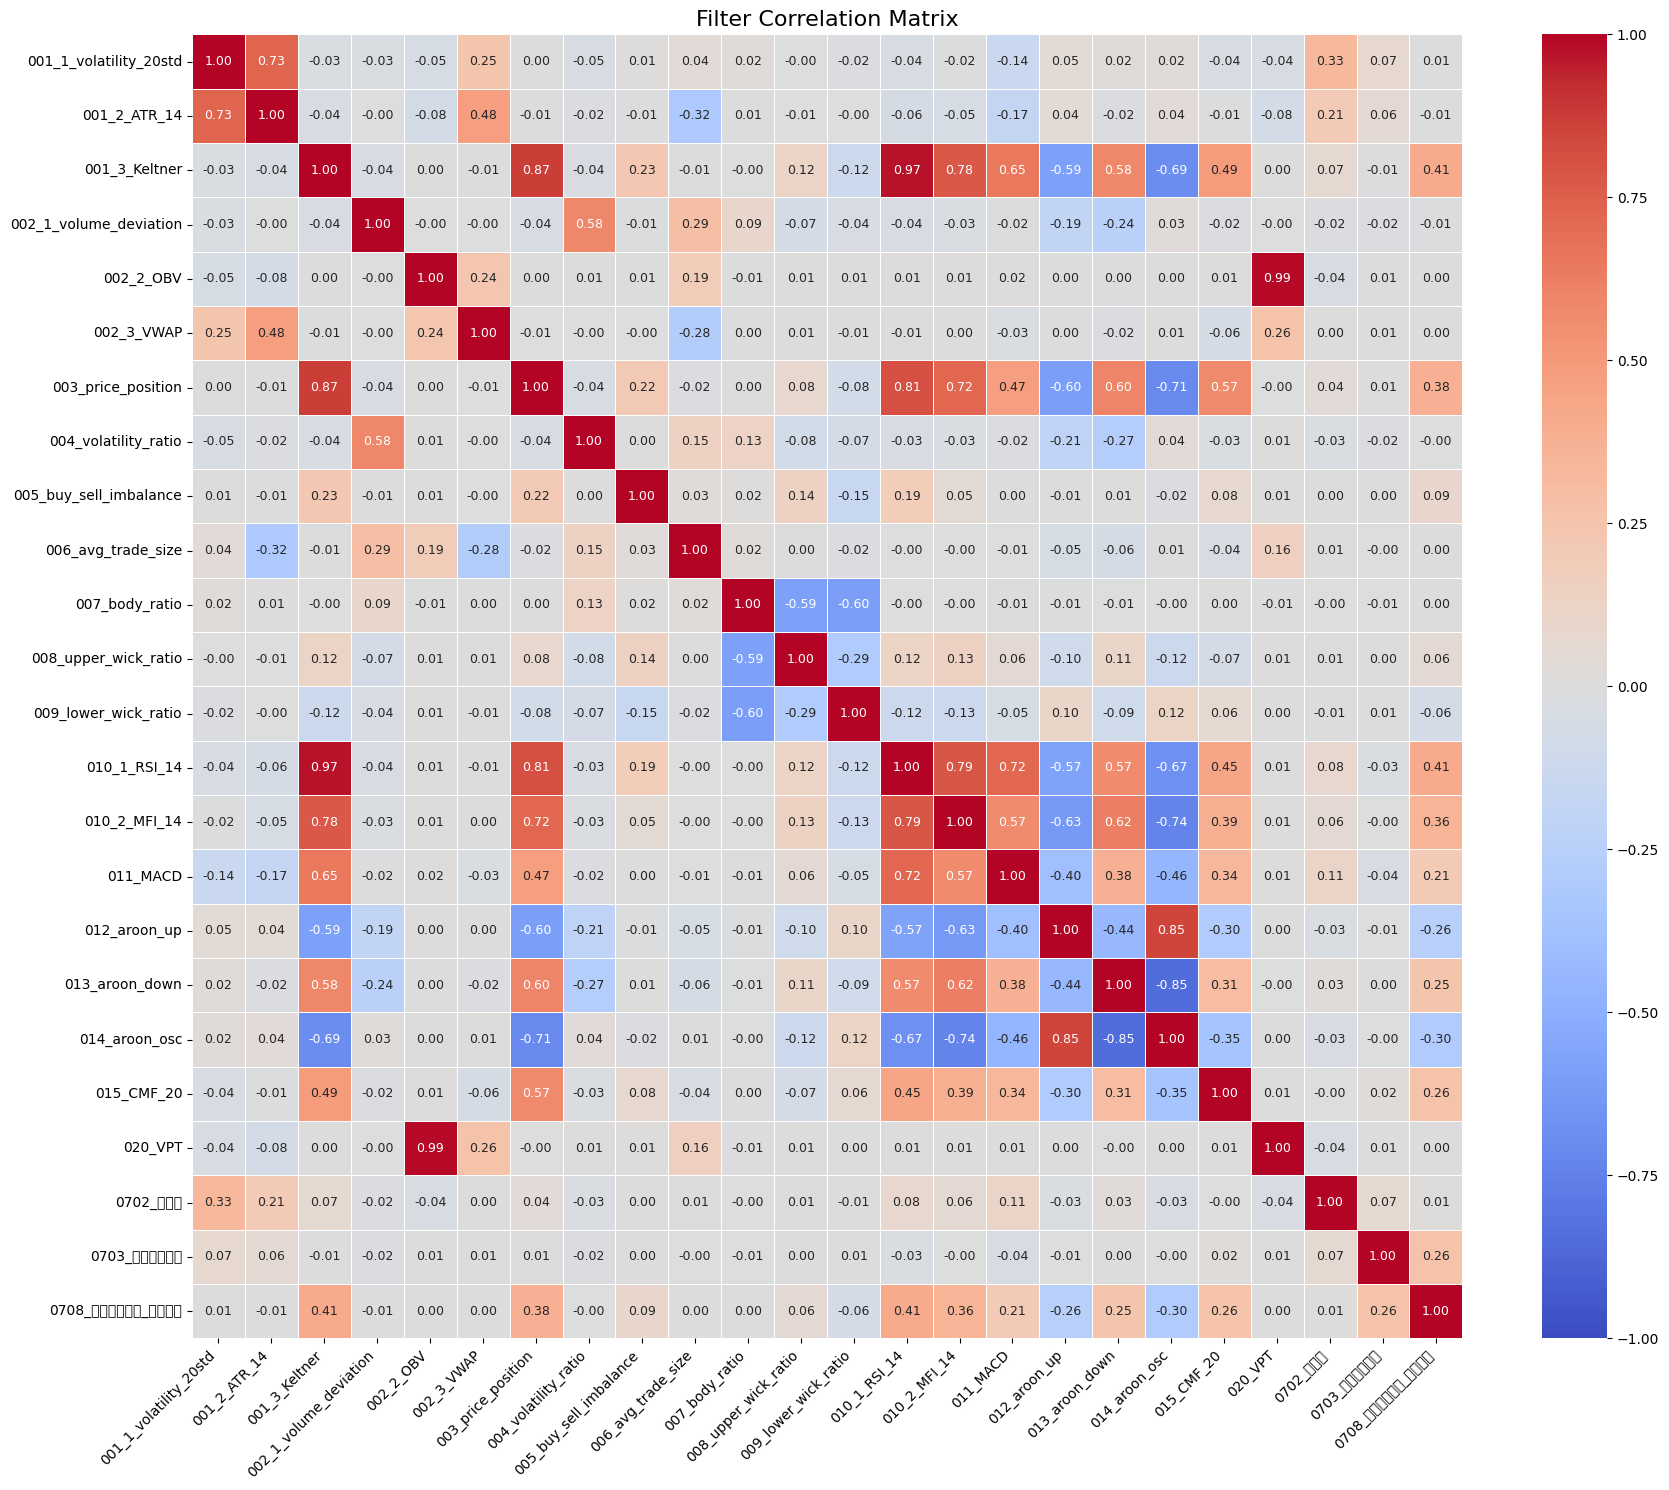

In [4]:
if __name__ == "__main__":
    corr_matrix, filter_results, high_corr_pairs = calculate_filter_correlations()
    plt.show()  # 显示热力图